In [1]:
import io
import heapq
import pickle
import urllib
import urllib.request
import heapq
from typing import List
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["axes.grid"] = True
pd.options.display.float_format = "{:,.8f}".format

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 1000)

__Feel free to use any resources at your disposal (google, stackoverflow, reddit, etc). Use python and any packages you deem necessary (pandas, numpy, etc) unless explicitly stated otherwise.__

# Question 1 - Data Extraction & Processing
As an engineer at Garda, a lot of our daily tasks involves reading in and processing vendor data in an efficient manner.  

Imagine we get tens of thousands of ticker order book files from a vendor in some folder. The file are named `AAPL.csv`, `AMZN.csv`, etc. Each of them being a few millions rows in length. Each of these files have 4 columns:
* `ticker` (e.g. text AAPL)
* `timestamp` (e.g. text 2024-09-10 03:00:00)
* `price` (e.g. float 518.09) 
* `qty` (e.g. int 84)  

You can assume the data in each file is ordered by timestamp. We would like to process these files line by line, ordered by timestamp, without having to read the files into memory all at once. 

**Requirements**  
* Write a script that prints out all entries from a list of file handlers `fds`, prepended by an index starting from 1 ordered by timestamp, one line at a time.  
* For us to be able to check your work, **instead of directly printing to the console, print to a `StringIO()` object. You can do `print(*args, file=aggregated_output)`**.  
* **DO NOT use pandas.read_csv() functions or one of its variants**, as we will test your function on a much larger set of input files set given here that will not fit into memory.


**Sample Output**  
1 AAPL,2024-09-10 09:30:00,692.25,-80  
2 AMZN,2024-09-10 09:31:00,1021.71,60  
3 AAPL,2024-09-10 09:31:01,492.67,8  
4 NVDA,2024-09-10 09:32:00,992.2,23  
....... (more lines of output omitted)  

In [2]:
# Here is the sample input files to use to test your code and produce the output
FILES = [
    "https://s3.amazonaws.com/coderbyteprojectattachments/gardacapitalpartners-g9rqd-g3h00dnv-AAPL.csv",
    "https://s3.amazonaws.com/coderbyteprojectattachments/gardacapitalpartners-g9rqd-0uy91twb-AMZN.csv",
    "https://s3.amazonaws.com/coderbyteprojectattachments/gardacapitalpartners-g9rqd-ixvkfvao-META.csv",
    "https://s3.amazonaws.com/coderbyteprojectattachments/gardacapitalpartners-g9rqd-5dfldc7i-NVDA.csv",
]

In [3]:
# DO NOT MODIFY
# use this for printing outputs
aggregated_output = io.StringIO()

# this code gives you a list of open file handlers to work with in fds
fds = set()
for file in FILES:
    fd = urllib.request.urlopen(file)
    fd.readline()  # skip over header line
    fds.add(fd)

In [ ]:
# WRITE YOUR CODE HERE
# Do not use pandas.read_csv() functions to read in entire files
# Instead read in one line at a time with fd.readline().rstrip().decode()

#Open all csv files - skip header 
#For each file, read the first line of data and store in `current_lines`.
#sort `current_lines` by timestamp
#Pick the line with the smallest timestamp and print it to the `aggregated_output` with an index number 
#Continue reading next line from the same file.
#adds it to the `current_lines` list and re-sorts the list by timestamp.
#Repeat above process until no more lines left in any of the files.

In [ ]:
# Initialize a list to store the current line from each file
current_lines = []
for fd in fds:
    line = fd.readline()
    if line:
        decoded_line = line.decode('utf-8').strip().split(",")
        current_lines.append((decoded_line[1], decoded_line, fd)) 

# Sort the initial lines by timestamp
current_lines.sort(key=lambda x: x[0])

# Initialize the index
index = 1

# Process the lines
while current_lines:
    # Get the earliest line
    earliest_timestamp, earliest_line, fd = current_lines.pop(0)
    
    # Print the line with the index
    output_line = f"{index} {earliest_line[0]},{earliest_line[1]},{earliest_line[2]},{earliest_line[3]}"
    print(output_line, file=aggregated_output)
    
    # Read the next line from the same file
    next_line = fd.readline()
    if next_line:
        decoded_next_line = next_line.decode('utf-8').strip().split(",")
        current_lines.append((decoded_next_line[1], decoded_next_line, fd))
        current_lines.sort(key=lambda x: x[0])  # Re-sort the list
    
    # Increment the index
    index += 1

# Print the aggregated output (for testing purposes)
# print(aggregated_output.getvalue())

In [5]:
# DO NOT MODIFY
# this code closes all open file handlers for you
for fd in fds:
    fd.close()

# Question 2 - Data Validation
Once we've aggregated vendor data into a readable csv format, we often need to do some data validation, making sure that the data we get fulfill certain expectations.

The following section asks you to implement three functions to perform data validation on an input dataframe `px_dirty` indexed by `date`:  
* `get_nulls()` asks you to return a sorted list of dates where the values are null/None
* `get_stales(n)` asks you to return a sorted list of dates where the values are stale for at least n consecutive business days.
* `get_outliers()` asks you to remove outliers that visually show up as obvious outliers, programmatically.  

For more detailed instuctions, refer to the docstrings of each function.  

**Do not modify the dataframe px_dirty in this section.**

In [5]:
from pandas.tseries.offsets import BDay
import pandas as pd
from typing import List

In [6]:
# this is the sample px_dirty input to use

px_dirty = pd.read_csv(
    "https://s3.amazonaws.com/coderbyteprojectattachments/gardacapitalpartners-g9rqd-asql40xi-px_dirty.csv.gz",
    parse_dates=["date"],
    index_col=0,
)
px_dirty

,value
date,
2000-01-03,56.03280000
2000-01-04,51.88220000
2000-01-05,49.98850000
2000-01-06,50.94830000
2000-01-07,52.53070000
...,...
2022-09-02,86.40000000
2022-09-06,85.13000000
2022-09-07,86.86000000


<AxesSubplot: xlabel='date'>

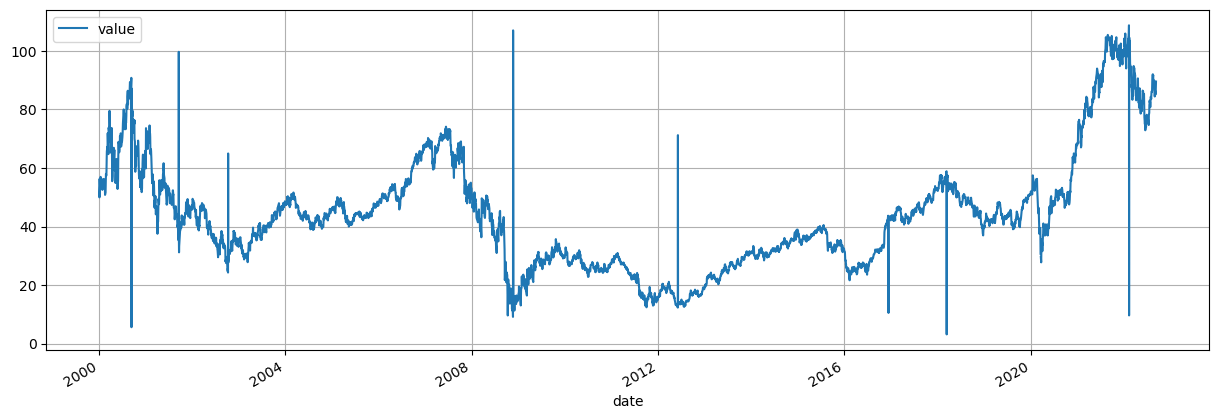

In [7]:
px_dirty.plot()

In [8]:
expected_output_hashed = {
    "dt_null": -5733373313213053561,
    "dt_stale": -6979858287102225919,
    "dt_outlier": 3064898596110849237,
}

In [9]:
def check_output(output, output_name):
    assert isinstance(output, list)
    if output_name == "dt_null":
        assert len(output) == 5 and pd.Timestamp(2014, 10, 8) in output
    elif output_name == "dt_stale":
        assert len(output) == 8 and pd.Timestamp(2020, 3, 16) in output
    elif output_name == "dt_outlier":
        assert len(output) == 8 and pd.Timestamp(2022, 2, 10) in output
    # feel free to comment the hash check out if it keeps failing and you
    # think your answer is correct. there might be a difference in coderbytes
    # python version and our local
    assert (
        hash(tuple([d.timestamp() for d in output]))
        == expected_output_hashed[output_name]
    )

In [10]:
%%time
# nulls - this should take roughly 1 ms
def get_nulls() -> List[pd.Timestamp]:
    """returns sorted list of dates where the values are null"""
    null_dates = px_dirty[px_dirty.isnull().any(axis=1)].index
    return sorted(null_dates.to_list())


# Run function and check output
dt_null = get_nulls()  # set to empty list if you couldn't solve it
check_output(dt_null, "dt_null")
dt_null

CPU times: user 3.96 ms, sys: 335 µs, total: 4.3 ms
Wall time: 7.78 ms


[Timestamp('2002-01-16 00:00:00'),
 Timestamp('2013-07-11 00:00:00'),
 Timestamp('2014-10-08 00:00:00'),
 Timestamp('2017-02-06 00:00:00'),
 Timestamp('2020-03-19 00:00:00')]

In [11]:
%%time
# stale - this should take roughly 4 ms
def get_stales(n=4) -> List[pd.Timestamp]:
    """
    returns sorted list of dates where the values are stale for
    at least n consecutive business days. do not include the 
    first date of occurrence. for instance, let's say the price 
    of AAPL shares remained at 100 from Aug 1, 2022 to Aug 5 2022, 
    the first occurrence of 100 is Aug 1. This is likely an actual 
    value. Thus, the price has been stale for 4 consecutive business 
    days.
    
    do not assume the date index contains every single business date. 
    if a price is missing Aug 4, then this is not consecutive. 
    missing prices are not the same as stale prices. using the example above, 
    this means Aug 2 and Aug 3 had stale prices, Aug 4 had a missing price, and 
    Aug 5 had the same price as Aug 1 (we can't determine whether this is stale 
    or a true value until the missing price is resolved realistically).
    """
    # Work on a copy of the DataFrame
    df = px_dirty.copy()
    
    # If the DataFrame's index holds dates, create a 'date' column from it
    df['date'] = pd.to_datetime(df.index)
    
    # Ensure the price column is named 'value' (adjust if necessary)
    # (Assuming your DataFrame px_dirty has a column named 'value')
    
    # 1. Identify breaks in successive values.
    m1 = df['value'].ne(df['value'].shift())
    
    # 2. Identify breaks in business days: we expect that the next date should be the previous date plus one business day.
    m2 = df['date'].ne(df['date'].shift().add(BDay()))
    
    # Group the DataFrame by the cumulative sum of the combined breaks.
    # Each time a break is encountered (either price changes or the next expected business day isn’t present),
    # the group counter increases.
    groups = (m1 | m2).cumsum()
    
    stale_dates = []
    # For each group of consecutive rows (where both the price and the business-day sequence are intact)
    for k, g in df.groupby(groups):
        # If the group is long enough that the price remained the same for at least n consecutive business days
        # (i.e. at least n+1 rows including the first occurrence)
        if len(g) >= n + 1:
            # The first occurrence is considered the actual value, so exclude it.
            # All subsequent dates in the group are stale.
            stale_dates.extend(g.iloc[1:]['date'].tolist())
    
    # Return the stale dates sorted in chronological order.
    return sorted(stale_dates)


# Run function and check output
dt_stale = get_stales()  # set to empty list if you couldn't solve it
check_output(dt_stale, "dt_stale")
dt_stale

CPU times: user 204 ms, sys: 16.9 ms, total: 221 ms
Wall time: 333 ms


[Timestamp('2019-07-19 00:00:00'),
 Timestamp('2019-07-22 00:00:00'),
 Timestamp('2019-07-23 00:00:00'),
 Timestamp('2019-07-24 00:00:00'),
 Timestamp('2020-03-11 00:00:00'),
 Timestamp('2020-03-12 00:00:00'),
 Timestamp('2020-03-13 00:00:00'),
 Timestamp('2020-03-16 00:00:00')]

In [12]:
%%time
# outliers - this should take roughly 3-4 ms
def get_outliers() -> List[pd.Timestamp]:
    """
    returns sorted list of dates where the values visually show up as obvious
    outliers as shown in the plot. practically we can't plot every single 
    timeseries in our database (there are hundreds of thousands) and eyeball 
    it. we have to build a program that can go through all of these points 
    and determine which points are potential outliers.
    """
    window_size = 30  # Adjust based on data characteristics
    threshold = 3  # Adjust dynamically

    # Compute rolling mean and rolling standard deviation
    rolling_mean = px_dirty["value"].rolling(window=window_size, center=True).mean()
    rolling_std = px_dirty["value"].rolling(window=window_size, center=True).std()

    # Identify outliers: values beyond threshold * rolling_std
    outlier_mask = np.abs(px_dirty["value"] - rolling_mean) > (threshold * rolling_std)
    outlier_dates = px_dirty[outlier_mask].index

    return sorted(outlier_dates)



# Run function and check output
dt_outlier = get_outliers()  # set to empty list if you couldn't solve it
check_output(dt_outlier, "dt_outlier")
dt_outlier

CPU times: user 5.16 ms, sys: 75 µs, total: 5.23 ms
Wall time: 6.69 ms


[Timestamp('2000-09-12 00:00:00'),
 Timestamp('2001-09-18 00:00:00'),
 Timestamp('2002-10-10 00:00:00'),
 Timestamp('2008-11-21 00:00:00'),
 Timestamp('2012-06-05 00:00:00'),
 Timestamp('2016-12-12 00:00:00'),
 Timestamp('2018-03-13 00:00:00'),
 Timestamp('2022-02-10 00:00:00')]

<AxesSubplot: xlabel='date'>

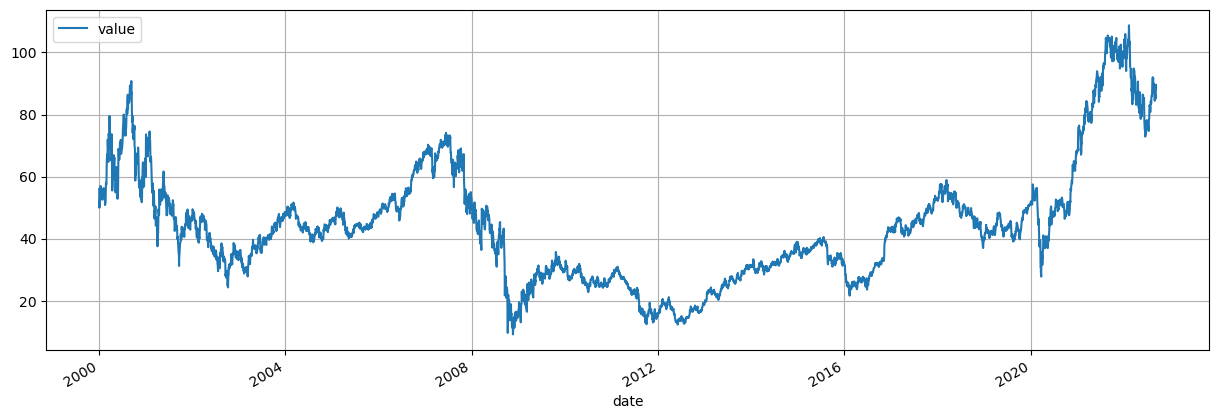

In [13]:
px_dirty.drop(index=dt_outlier).plot()

# Pickle Your Answers

In [14]:
output = dict(
    order=aggregated_output.getvalue(),
    null=dt_null,
    stale=dt_stale,
    outlier=dt_outlier,
)

In [15]:
with open("submitted_output.pkl", "wb") as f:
    pickle.dump(output, f, protocol=pickle.HIGHEST_PROTOCOL)